In [1]:
import numpy as np
import torch
import sklearn.datasets

from utils.preprocess import preprocess_data
from utils.loss import nll
from utils.helpers import generate_sign_patterns, get_out_string
from utils.cvxpy_model import cvxpy_solver
from utils.pytorch_model import sgd_solver
from utils.visualization import get_times_epoch_xaxis, plot_metrics_over_time

## Load Data

In [2]:
# rcv1
base_dir = 'all_data/vector_data/rcv1/rcv1_all_subset.binary_'
output_dir = 'outputs/rcv1/'
names = ['train', 'valid', 'test']
files = [base_dir + ds + '_voc_150.amat' for ds in names]
d_tuples = [np.loadtxt(file) for file in files]
X_tr, X_v, X_tst = [data[:, :-1] for data in d_tuples]
X_train, y_train, X_valid, y_valid, X_test, y_test, D = preprocess_data(X_tr, X_v, X_tst, r=10)

In [10]:
# generate random sign patterns
P, verbose = 50, True # SET verbose to True to see progress
sign_pattern_list, u_vector_list = generate_sign_patterns(X_train, P, verbose)
num_neurons = len(sign_pattern_list)
num_epochs, batch_size = 5000, 100
beta_noncvx = 1e-3
learning_rate = 1e-3

Number of unique sign patterns generated: 50


## NN

In [11]:
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
results_noncvx = sgd_solver(X_train, y_train, X_valid, y_valid, 
                            num_epochs, num_neurons, beta_noncvx, 
                            learning_rate, batch_size, solver_type, 
                            LBFGS_param, D, verbose=verbose, eps=1e-2, 
                            last_n=10)

Epoch [0/2], TRAIN: nll: 76.384, loss: 76.394, acc: 0.579.
	     TEST: nll: 82.421, loss: 82.421, acc: 0.417.
Epoch [1/2], TRAIN: nll: 75.794, loss: 75.804, acc: 0.587.
	     TEST: nll: 83.444, loss: 83.444, acc: 0.448.

TRAIN:  ZEROS nll: 85.56800079345703, loss: 85.568, acc: 0.41200000047683716.
	ONES nll: 66.0199966430664, loss: 66.02, acc: 0.7630000114440918.
TEST:   ZEROS nll: 85.53099822998047, loss: 85.531, acc: 0.4099999964237213.
	ONES nll: 65.99199676513672, loss: 65.992, acc: 0.7630000114440918.


## PyTorch - hinge loss

In [12]:
# SGD solver for the convex problem
beta_cvx = 2 * beta_noncvx
rho = 1e-4
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
learning_rate = 1e-3
results_pt_hinge = sgd_solver(X_train, y_train, X_valid, y_valid, 
                              num_epochs, num_neurons, beta_cvx,
                              learning_rate, batch_size, solver_type, 
                              LBFGS_param, D, rho=rho, convex=True,
                              u_vector_list=u_vector_list, verbose=verbose,
                              eps=1e-2, last_n=10)

Epoch [0/2], TRAIN: nll: 69.645, loss: 69.672, acc: 0.655.
	     TEST: nll: 74.877, loss: 74.886, acc: 0.723.
Epoch [1/2], TRAIN: nll: 68.217, loss: 68.257, acc: 0.66.
	     TEST: nll: 73.672, loss: 73.685, acc: 0.733.

TRAIN:  ZEROS nll: 75.53399658203125, loss: 75.547, acc: 0.75.
	ONES nll: 60.9010009765625, loss: 60.919, acc: 0.5699999928474426.
TEST:   ZEROS nll: 75.2239990234375, loss: 75.237, acc: 0.753000020980835.
	ONES nll: 60.69300079345703, loss: 60.711, acc: 0.5699999928474426.


## PyTorch - relaxed

In [13]:
# SGD solver for the convex problem
beta_cvx = 2 * beta_noncvx
solver_type = "sgd" # pick: "sgd" or "LBFGS"
LBFGS_param = [10, 4] # these parameters are for the LBFGS solver
learning_rate = 1e-3
results_pt_relaxed = sgd_solver(X_train, y_train, X_valid, y_valid, 
                                num_epochs, num_neurons, beta_cvx,
                                learning_rate, batch_size, solver_type, 
                                LBFGS_param, D, rho=0, convex=True,
                                u_vector_list=u_vector_list, verbose=verbose, 
                                eps=1e-2, last_n=10)

Epoch [0/2], TRAIN: nll: 69.651, loss: 69.668, acc: 0.655.
	     TEST: nll: 74.696, loss: 74.696, acc: 0.715.
Epoch [1/2], TRAIN: nll: 68.215, loss: 68.239, acc: 0.662.
	     TEST: nll: 73.724, loss: 73.724, acc: 0.762.

TRAIN:  ZEROS nll: 75.59500122070312, loss: 75.595, acc: 0.7850000262260437.
	ONES nll: 60.834999084472656, loss: 60.835, acc: 0.5389999747276306.
TEST:   ZEROS nll: 75.29000091552734, loss: 75.29, acc: 0.7879999876022339.
	ONES nll: 60.625, loss: 60.625, acc: 0.5389999747276306.


## CVXPY - exact

In [5]:
# CVXPY solver for the convex problem
max_iters = 2000
solver_type = 'SCS' #'ECOS', 'OSQP', or 'SCS'
beta_cvx = 2 * beta_noncvx
batch_size = 1000
results_cp_exact = cvxpy_solver(X_train, y_train, X_valid, y_valid, 
                                max_iters, num_neurons, beta_cvx, 
                                solver_type, D, u_vector_list, 
                                batch_size=batch_size, verbose=True)

created problem
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 6844688
eps = 1.00e-04, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 4200, constraints m = 5008300
Cones:	linear vars: 5001200
	soc vars: 1100, soc blks: 100
	exp vars: 6000, dual exp vars: 0
Setup time: 3.41e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 1.16e+20  2.99e+22  1.00e+00 -8.07e+18  5.20e+24  1.24e+25  7.70e-01 
   100| 7.61e-03  2.35e+00  9.96e-01  2.70e+02 -0.00e+00  1.52e-14  7.83e+01 
   200| 6.71e-05  1.08e-01  4.77

## CVXPY - relaxed

In [6]:
# CVXPY solver for the convex problem
# max_iters = 100
solver_type = 'SCS' #'ECOS', 'OSQP', or 'SCS'
beta_cvx = 2 * beta_noncvx
batch_size = 100000 #X_train.shape[0]
results_cp_relaxed = cvxpy_solver(X_train, y_train, X_valid, y_valid, 
                                  max_iters, num_neurons, beta_cvx, 
                                  solver_type, D, u_vector_list,
                                  batch_size=batch_size,
                                  exact=False, verbose=True)

created problem
----------------------------------------------------------------------------
	SCS v2.1.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 7625142
eps = 1.00e-04, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
acceleration_lookback = 10, rho_x = 1.00e-03
Variables n = 301200, constraints m = 701300
Cones:	linear vars: 100200
	soc vars: 1100, soc blks: 100
	exp vars: 600000, dual exp vars: 0
Setup time: 1.53e+01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 5.61e+21  6.43e+23  1.00e+00 -1.04e+21  1.09e+26  1.40e+26  4.20e+00 
   100| 7.51e-03  9.83e-01  9.86e-01  5.26e+02  3.14e+00  2.06e-12  9.07e+01 
   200| 1.39e-03  1.08e-01  6.

## Visualization

In [14]:
times_nc, epoch_times_nc, xaxis_nc = get_times_epoch_xaxis(results_noncvx, num_epochs)
times_pth, epoch_times_pth, xaxis_pth = get_times_epoch_xaxis(results_pt_hinge, num_epochs)
times_ptr, epoch_times_ptr, xaxis_ptr = get_times_epoch_xaxis(results_pt_relaxed, num_epochs)
times_cpe, epoch_times_cpe, xaxis_cpe = get_times_epoch_xaxis(results_cp_exact, num_epochs, cvxpy=True)
times_cpr, epoch_times_cpr, xaxis_cpr = get_times_epoch_xaxis(results_cp_relaxed, num_epochs, cvxpy=True)

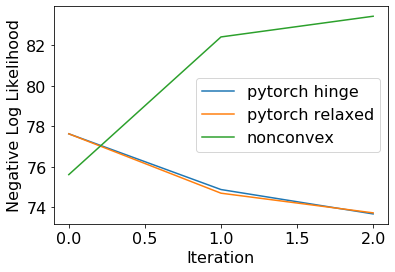

In [15]:
plot_metrics_over_time(xaxis_pth=xaxis_pth, results_pt_hinge=results_pt_hinge)
plot_metrics_over_time(xaxis_ptr=xaxis_ptr, results_pt_relaxed=results_pt_relaxed)
plot_metrics_over_time(xaxis_nc=xaxis_nc, results_noncvx=results_noncvx)

In [16]:
out_str = get_out_string(results_noncvx, results_pt_hinge, results_pt_relaxed, 
                         results_cp_exact, results_cp_relaxed, epoch_times_nc, 
                         epoch_times_pth, epoch_times_ptr, X_test, y_test, D)
print(out_str)
file = open('outputs/rcv1/out.txt', 'w')
file.write(out_str)
file.close()

IndexError: index -10 is out of bounds for axis 0 with size 3